In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
# Set seed for replayability
from numpy.random import seed 
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
pd.options.mode.chained_assignment = None  # default='warn'


# <span style='font-family:"Times New Roman"'> <span styel=''>Data pre-processing

In [2]:
# Read data
df = pd.read_csv('NewCases_Data/export_dataframe.csv')
df


,date,newCasesByPublishDate,newDeaths28DaysByPublishDate,newAdmissions,hospitalCases,covidOccupiedMVBeds,London
0,2020-04-21,4301,1224,1713,19139,3036,0.09
1,2020-04-22,4451,847,1527,18533,2964,0.09
2,2020-04-23,4583,682,1513,17867,2867,0.09
3,2020-04-24,5386,1010,1525,17063,2703,0.09
4,2020-04-25,4913,815,1255,16604,2702,0.08
...,...,...,...,...,...,...,...
291,2021-02-06,18262,828,1880,26881,3373,0.21
292,2021-02-07,15845,373,1846,26767,3302,0.21
293,2021-02-08,14104,333,1909,26706,3230,0.24
294,2021-02-09,12364,1052,1743,25643,3164,0.22


In [3]:
df_data = df[['date','newCasesByPublishDate','newDeaths28DaysByPublishDate'
             ,'newAdmissions','hospitalCases','covidOccupiedMVBeds','London']]
df_data


,date,newCasesByPublishDate,newDeaths28DaysByPublishDate,newAdmissions,hospitalCases,covidOccupiedMVBeds,London
0,2020-04-21,4301,1224,1713,19139,3036,0.09
1,2020-04-22,4451,847,1527,18533,2964,0.09
2,2020-04-23,4583,682,1513,17867,2867,0.09
3,2020-04-24,5386,1010,1525,17063,2703,0.09
4,2020-04-25,4913,815,1255,16604,2702,0.08
...,...,...,...,...,...,...,...
291,2021-02-06,18262,828,1880,26881,3373,0.21
292,2021-02-07,15845,373,1846,26767,3302,0.21
293,2021-02-08,14104,333,1909,26706,3230,0.24
294,2021-02-09,12364,1052,1743,25643,3164,0.22


In [4]:
# Separate dates for future plotting
all_dates = pd.to_datetime(df_data['date'])

# Extract features
n_features = 6
cols = list(df_data)[1:n_features + 1]
data = df_data[cols].astype(float)

# Split into the train set and the test set
split = 0.75
x = int(data.shape[0] * split)
train_set, test_set = data[:x], data[x:]
print("train set:", train_set.shape)
print("test set:", test_set.shape)


train set: (222, 6)
test set: (74, 6)


In [5]:
# Number of days predicted into the future
n_future = 5

# Number of past days used as the input
n_past = 4

# Normalize the train set
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
train_data_scaled = scaler.transform(train_set)

print("train set size:", train_data_scaled.shape)
print("train set type:", type(train_data_scaled))


train set size: (222, 6)
train set type: <class 'numpy.ndarray'>


In [6]:
# Reshape input and output
train_X, train_Y = [], []

for i in range(n_past, train_data_scaled.shape[0] - n_future + 1):
    train_X.append(train_data_scaled[i - n_past:i, 0:train_data_scaled.shape[1]])
    train_Y.append(train_data_scaled[i:i + n_future, 0])

train_x, train_y = np.array(train_X), np.array(train_Y)

print("train x:", train_x.shape)
print("train y:", train_y.shape)


train x: (214, 4, 6)
train y: (214, 5)


# <span style='font-family:"Times New Roman"'> <span styel=''>Model training

In [7]:
# LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))

model.compile(optimizer='adam', loss='mse')

# Training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='max')
history = model.fit(train_x, train_y, epochs=100, batch_size=10, validation_split=0.1, verbose=1, callbacks=[reduce_lr])


Epoch 1/100
20/20 [==============================] - 1s 28ms/step - loss: 0.6538 - val_loss: 0.1606
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5145 - val_loss: 0.1763
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2918 - val_loss: 0.1738
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1140 - val_loss: 0.1365
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0774 - val_loss: 0.1005
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0727 - val_loss: 0.0845
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0698 - val_loss: 0.0823
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0530 - val_loss: 0.0745
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0530 - val_loss: 0.0725
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0414 - val_loss: 0.0705
Epoch 11

20/20 [==============================] - 0s 5ms/step - loss: 0.0393 - val_loss: 0.0729
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0453 - val_loss: 0.0729
Epoch 85/100
20/20 [==============================] - ETA: 0s - loss: 0.043 - 0s 4ms/step - loss: 0.0415 - val_loss: 0.0729
Epoch 86/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0356 - val_loss: 0.0729
Epoch 87/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0393 - val_loss: 0.0729
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0377 - val_loss: 0.0729
Epoch 89/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0393 - val_loss: 0.0729
Epoch 90/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0434 - val_loss: 0.0729
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0420 - val_loss: 0.0729
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0396 - val_lo

# <span style='font-family:"Times New Roman"'> <span styel=''>Model validation

Text(0.5, 1.0, 'model train vs validation loss')

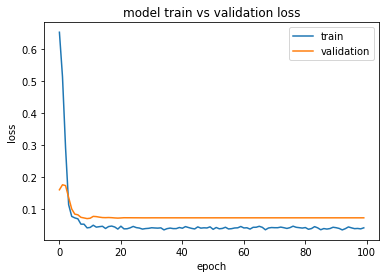

In [8]:
# Plot model train vs validation loss
sns.lineplot(data=history.history['loss'])
sns.lineplot(data=history.history['val_loss'])
plt.legend(labels=['train', 'validation'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("model train vs validation loss")


# <span style='font-family:"Times New Roman"'> <span styel=''>Model testing

In [9]:
# Reshape input and output
test_data_scaled = scaler.transform(test_set)

test_X, test_Y = [], []

for i in range(n_past, test_data_scaled.shape[0] - n_future + 1):
    test_X.append(test_data_scaled[i - n_past:i, 0:test_data_scaled.shape[1]])
    test_Y.append(test_data_scaled[i:i + n_future, 0])

test_x, test_y = np.array(test_X), np.array(test_Y)

print("test x shape:", test_x.shape)
print("test y shape:", test_y.shape)


test x shape: (66, 4, 6)
test y shape: (66, 5)


In [10]:
results = model.evaluate(test_x, test_y)
predict_y = model.predict(test_x)
model_y = model.predict(train_x)


# Inverse transform for multiple output
def inverse_transform(data):
    for i in range(len(data)):
        data_copies = data[i]
        data_copies = np.repeat(data_copies[:, np.newaxis], train_set.shape[1], 1)
        data[i] = scaler.inverse_transform(data_copies)[:, 0]
    return data


predict_y = inverse_transform(predict_y)
test_y = inverse_transform(test_y)
model_y = inverse_transform(model_y)
train_y = inverse_transform(train_y)


# Evaluate per-day predictions
def perDay_rmse(tests, predictions):
    for i in range(n_future):
        actual = [test[i] for test in tests]
        predicted = [prediction[i] for prediction in predictions]
        rmse = mean_squared_error(actual, predicted, squared=False)
        print('Day-%d RMSE is %f' % ((i + 1), rmse))


print("validation:")
perDay_rmse(train_y[int(-0.1 * len(train_x)) - 1:], model_y[int(-0.1 * len(train_x)) - 1:])

print("*"*40)
print("test:")
perDay_rmse(test_y, predict_y)


3/3 [==============================] - 0s 2ms/step - loss: 0.4714
validation:
Day-1 RMSE is 4440.240088
Day-2 RMSE is 4329.451971
Day-3 RMSE is 4572.757666
Day-4 RMSE is 4585.011536
Day-5 RMSE is 4426.316056
****************************************
test:
Day-1 RMSE is 10151.710400
Day-2 RMSE is 9995.486611
Day-3 RMSE is 11385.406698
Day-4 RMSE is 12871.119985
Day-5 RMSE is 12181.190245


##### 